# Capstone

## Research Question 1: Mortality Prediction in ICU 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately **predict mortality** based on data from the **first 24 hours in ICU**?

## Research Question 2: Weekend Effect in ICU 

Objective: To develop a statistical model to estimate the effect of **weekend admission to ICU** on the **risk of ICU mortality**. 

Question: Does admission to ICU over the weekend increase the risk of mortality? 

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
FILE_PATH = 'raw_data/'
FILE_EXTENSION = '.csv'
INPUT_DATA_DIR = 'input/input.csv'
STARTING_TABLES  = \
['pt_icu_outcome', 'vitals_hourly', 'labs_hourly', 'gcs_hourly', 'admissions']
FILE_DIR = [FILE_PATH + name + FILE_EXTENSION for name in STARTING_TABLES]

# data ingestion
raw_icu = pd.read_csv(FILE_DIR[0])
raw_vitals = pd.read_csv(FILE_DIR[1])
raw_labs = pd.read_csv(FILE_DIR[2])
raw_gcs = pd.read_csv(FILE_DIR[3]) #Glasgow Coma Score
raw_ad = pd.read_csv(FILE_DIR[4])

# ETL - admission
pt_icu_cleaned = pt_icu_etl(raw_icu)
admission_cleaned = admission_etl_function(raw_ad)
first_24_vital_agg = hourly_vitals_etl(raw_vitals)
first_24_gcs_agg = hourly_gcs_etl(raw_gcs)
first_24_labs_agg = hourly_labs_etl(raw_labs)

icu_n_admission = pd.merge(pt_icu_cleaned, 
                           admission_cleaned, 
                           how='inner', on='hadm_id')
icu_n_vital = pd.merge(icu_n_admission, 
                       first_24_vital_agg, 
                       how='inner', on='icustay_id')
icu_n_gcs = pd.merge(icu_n_vital, 
                     first_24_gcs_agg, 
                     how='inner', on='icustay_id')
icu_n_labs = pd.merge(icu_n_gcs, 
                      first_24_labs_agg, 
                      how='inner', on='icustay_id')

cols_to_drop_final = \
['row_id', 'dob', 'hadm_id', 'subject_id', 'admittime', 'dischtime',
 'icustay_id', 'age_years', 'intime', 'outtime','hosp_deathtime',
 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag',
 'ttd_days', 'icu_adm_weekend', 'ttd_bins']
pt_icu_final = icu_n_labs.drop(cols_to_drop_final, axis=1)
pt_icu_final.to_pickle("input/input.pkl")

In [5]:
pt_icu_final

,los,standard_mortality_label,age_bins_under20,age_bins_20-40,age_bins_40-60,age_bins_60-80,age_bins_over80,intime_weekday_Friday,intime_weekday_Monday,intime_weekday_Saturday,...,abnorm_bicarbonate,abnorm_troponin,abnorm_bloodureanitrogen,abnorm_partialpressureo2,abnorm_creatinine,abnorm_glucose,abnorm_neutrophil,abnorm_creactiveprotein,abnorm_lactate,abnorm_inr
0,6.0646,False,0,0,0,1,0,0,0,0,...,3,0,1,6,1,4,1,0,4,1
1,1.6785,False,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1
2,3.6729,False,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,2
3,5.3231,True,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,3,0
4,1.5844,False,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51060,11.2998,False,0,0,1,0,0,0,1,0,...,1,0,0,4,0,0,1,0,1,1
51061,3.1426,False,0,0,1,0,0,0,0,0,...,2,0,1,1,0,0,1,0,1,1
51062,1.9745,False,0,0,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
51063,2.1615,False,0,0,0,0,1,0,0,0,...,2,0,0,4,2,0,0,0,0,2


Label Balance in counts:
False    47368
True      3697
Name: standard_mortality_label, dtype: int64
Label Balance in ratio:
False   0.9276
True    0.0724
Name: standard_mortality_label, dtype: float64


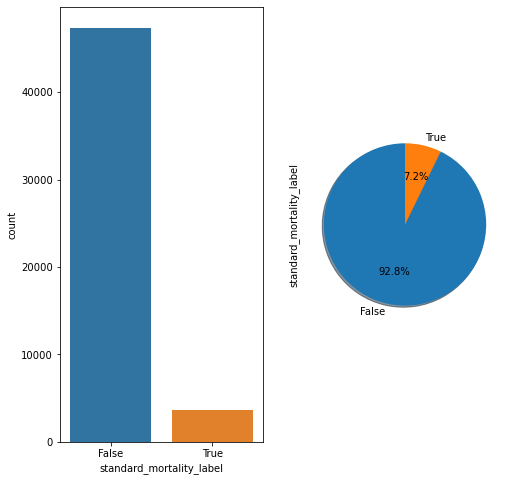

In [7]:
df = pd.read_pickle("input/input.pkl")

labels = [False, True]
fig, ax = plt.subplots(1,2, figsize=(8,8))
sns.countplot(df['standard_mortality_label'], ax=ax[0])
df.standard_mortality_label.value_counts().\
    plot.pie(labels=labels, autopct='%.1f%%', shadow=True, startangle=90)
print('Label Balance in counts:')
print(df.standard_mortality_label.value_counts())
print('Label Balance in ratio:')
print(df.standard_mortality_label.value_counts(normalize=True))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
los,51065.0,NaN,NaN,NaN,4.2277,6.1909,0.1825,1.2473,2.1878,4.2704,173.0725
age_bins_under20,51065.0,NaN,NaN,NaN,0.0109,0.1041,0.0,0.0,0.0,0.0,1.0
age_bins_20-40,51065.0,NaN,NaN,NaN,0.0949,0.2931,0.0,0.0,0.0,0.0,1.0
age_bins_40-60,51065.0,NaN,NaN,NaN,0.2946,0.4559,0.0,0.0,0.0,1.0,1.0
age_bins_60-80,51065.0,NaN,NaN,NaN,0.4185,0.4933,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
abnorm_glucose,51065.0,NaN,NaN,NaN,0.2793,0.799,0.0,0.0,0.0,0.0,17.0
abnorm_neutrophil,51065.0,NaN,NaN,NaN,0.193,0.4465,0.0,0.0,0.0,0.0,5.0
abnorm_creactiveprotein,51065.0,NaN,NaN,NaN,0.0067,0.0852,0.0,0.0,0.0,0.0,2.0
abnorm_lactate,51065.0,NaN,NaN,NaN,0.8458,1.6953,0.0,0.0,0.0,1.0,21.0


<Figure size 432x288 with 0 Axes>

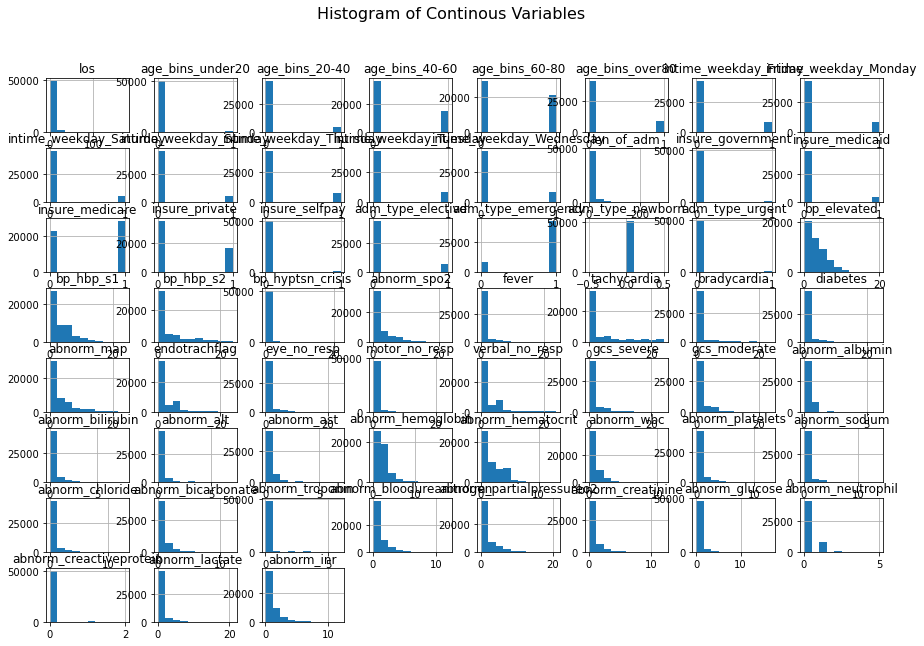

In [21]:
TARGETS = ['standard_mortality_label']
# fast data inspection
display(df.drop(TARGETS, axis=1).describe(include='all').T)
fig= plt.figure()
df.drop(TARGETS, axis=1).hist(figsize=(15,10))
plt.suptitle('Histogram of Continous Variables', size = 16)
plt.show()

In [22]:
#X = df.drop(['ever_booked',''], axis=1) #feature set
X = df.drop(['standard_mortality_label'], axis=1) #feature set
y = df[['standard_mortality_label']] #target set

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    test_size = 0.2, stratify = y)

# Normalise feature for baseline model
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# packages for model pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
# packages for model performance evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score # Area under PR curve
from sklearn.metrics import matthews_corrcoef # Matthews Correlation Coefficient <- for ranking only
from sklearn.metrics import cohen_kappa_score # Cohen's kappa
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

# Transformer for pipeline
scaler = StandardScaler()

# Unbalanced dataset
average_precision_scorer = make_scorer(average_precision_score)
f1_scorer = make_scorer(f1_score)
cohens_kappa_scorer = make_scorer(cohen_kappa_score)
matthew_corrcoe_scorer = make_scorer(matthews_corrcoef)
scoring = {'AP': average_precision_scorer,
           'F1': f1_scorer, 
           'CK': cohens_kappa_scorer,
           'MC': matthew_corrcoe_scorer,}

In [25]:
def baseline_model_performance(dictionary_of_algos, X_train, y_train, X_test, y_test, labels):
    """passing list of algorithms to run and compare baseline performance
    also need to pass in training and test feature sets and target sets
    and list of labels for confusion matrix visualisation"""
    for key, classifier in dictionary_of_algos.items():
        start = time.time()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)[:,1]
        end = time.time()
        used = end - start
        # Confusion Matrix
        cm = confusion_matrix(y_pred, y_test)
        # ROC True Positive Rate, False Positive Rate
        fpr, tpr, thresholds0 = roc_curve(y_test, y_pred_proba)
        # Precision and Recall
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        # F1 Score
        f1 = f1_score(y_test, y_pred)
        # Accuracy
        accuracy = classifier.score(X_test_scaled, y_test)
        # ROC_AUC, PR_AUC
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        print('\n')
        print('--------'+key+' Baseline Model---------')
        print('\n')
        # Print Baseline Results
        print("Job took: {}s".format(used))
        print("Baseline Model parameters:\n {}".format(classifier.get_params))
        print("Best cross-validation score (Accuracy): {:.4f}".format(classifier.score(X_test, y_test)))
        print('Accuracy: {0:.3f} \nF1-score: {1:.3f} \nPR_AUC: {2:.3f} \nROC_AUC: {3:.3f} \n'.
              format(accuracy, f1, pr_auc, roc_auc))
        print(classification_report(y_test, y_pred))
        print('\n')
        plt.style.use('seaborn')
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        sns.heatmap(cm, annot=True, fmt='.0f', ax=ax,
                    cmap="Dark2", norm=colors.PowerNorm(gamma=0.5)
                    , annot_kws={"size": 14})
        ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
        ax.set_title('Confusion Matrix', fontsize=14); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
        plt.show()



--------Logistic Regression Baseline Model---------


Job took: 0.4764430522918701s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of LogisticRegression(n_jobs=-1, random_state=0, solver='liblinear')>
Best cross-validation score (Accuracy): 0.9450
Accuracy: 0.945 
F1-score: 0.471 
PR_AUC: 0.578 
ROC_AUC: 0.880 

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      9474
        True       0.77      0.34      0.47       739

    accuracy                           0.94     10213
   macro avg       0.86      0.67      0.72     10213
weighted avg       0.94      0.94      0.93     10213





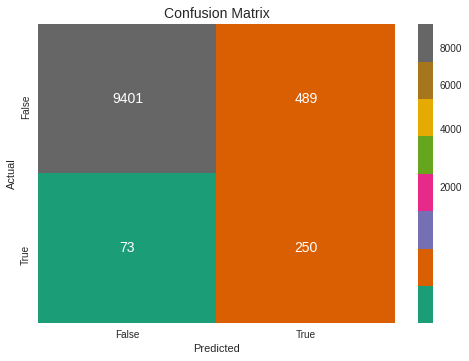



--------XG Boost Baseline Model---------


Job took: 1.1833679676055908s
Baseline Model parameters:
 <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'map', 'aucpr'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>
Best cross-validation score (Accuracy): 0.9595
Accuracy: 0.959 
F1-score: 0.660 
PR_AUC: 0.747 
ROC_AUC: 0.942 

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      9474
 

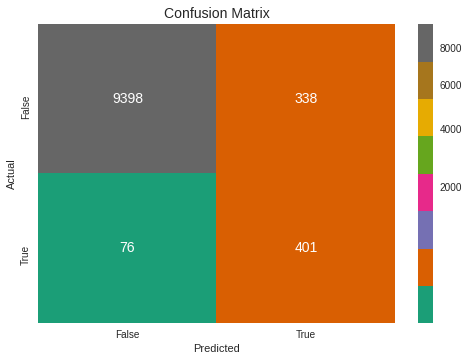



--------Random Forest Baseline Model---------


Job took: 0.5211927890777588s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of RandomForestClassifier(n_jobs=-1, random_state=0)>
Best cross-validation score (Accuracy): 0.9528
Accuracy: 0.953 
F1-score: 0.530 
PR_AUC: 0.697 
ROC_AUC: 0.915 

              precision    recall  f1-score   support

       False       0.95      1.00      0.98      9474
        True       0.95      0.37      0.53       739

    accuracy                           0.95     10213
   macro avg       0.95      0.68      0.75     10213
weighted avg       0.95      0.95      0.94     10213





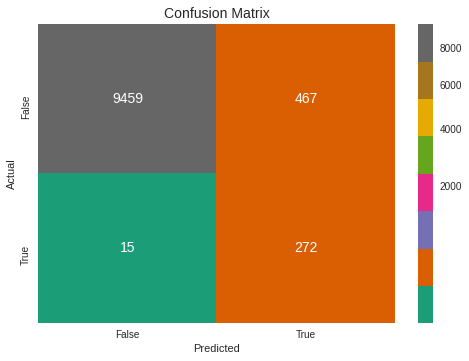



--------Gradient Boosted Tree Baseline Model---------


Job took: 6.486379146575928s
Baseline Model parameters:
 <bound method BaseEstimator.get_params of GradientBoostingClassifier(random_state=0)>
Best cross-validation score (Accuracy): 0.9571
Accuracy: 0.957 
F1-score: 0.614 
PR_AUC: 0.722 
ROC_AUC: 0.933 

              precision    recall  f1-score   support

       False       0.96      1.00      0.98      9474
        True       0.88      0.47      0.61       739

    accuracy                           0.96     10213
   macro avg       0.92      0.73      0.80     10213
weighted avg       0.95      0.96      0.95     10213





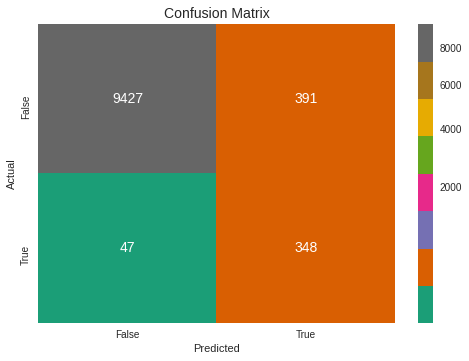

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.colors as colors
from xgboost import XGBClassifier

RFC = RandomForestClassifier(random_state=0, n_jobs=-1)
LR = LogisticRegression(random_state=0, solver='liblinear', n_jobs=-1)
#SVC = SVC(random_state=0, gamma='scale', probability=True)
GBC = GradientBoostingClassifier(random_state=0)
XGB = XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric=['error','map','aucpr']
#                     verbosity=0, gamma = 0.2, max_depth=6, min_child_weight=9,
#                     scale_pos_weight=9, n_estimators=1000, subsample=0.8, learning_rate=0.1,
#                     colsample_bytree=0.8, 
                   ) 
#param set after tuning
algo_dict = {'Logistic Regression': LR,
             'XG Boost': XGB,
             'Random Forest': RFC,
             'Gradient Boosted Tree': GBC,
            }
labels = ['False', 'True']  

# compare your results        
baseline_model_performance(algo_dict, X_train_scaled, y_train, X_test_scaled, y_test, labels)

In [29]:
from sklearn.model_selection import RandomizedSearchCV

def tuning_models_RSCV(X_train, y_train, X_test, y_test, labels, nested_dict_of_models_params, scaler, scoring, refit_measure='F1'):
    """"""
    models = []
    time_used = []
    best_cv_scores = []
    roc_test_set = []
    pr_test_set = []
    f1_test_set = []
    ap_test_set = []
    mc_test_set = []
    ck_test_set = []
    acc_test_set = []
    tn_count = []
    fp_count = []
    fn_count = []
    tp_count = []
    tuned_models = []
    
    for model, details in nested_dict_of_models_params.items():
        models.append(model)
        clf = details['clf']
        params = details['params']        
        
        pipeline = Pipeline([('Transformer', scaler), ('Estimator', clf)])

        start = time.time()
        # Repeated Stratified K-Fold Cross-Validation set:
        cv = StratifiedShuffleSplit(n_splits=7, test_size=0.3, random_state=0)
        grid = RandomizedSearchCV(pipeline, params, cv=cv, n_jobs=-1, scoring=scoring, refit=refit_measure)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test) #model prediction
        y_pred_proba = grid.predict_proba(X_test)[:,1] #prediction probability
        end = time.time()
        used = end - start #time the computation
        tuned_models.append(grid)
        time_used.append(used)
        best_cv_scores.append(grid.best_score_)

        # For Visualisation - Confusion Matrix
        cm = confusion_matrix(y_pred, y_test)
        tn, fp, fn, tp = cm.ravel()
        tn_count.append(tn)
        fp_count.append(fp)
        fn_count.append(fn)
        tp_count.append(tp)

        # For Visualisation - ROC, False Positive Rate, True Positive Rate
        fpr, tpr, thresholds0 = roc_curve(y_test, y_pred_proba)

        # For Visualisation - Precision, Recall
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred_proba)
        mc = matthews_corrcoef(y_test, y_pred)
        ck = cohen_kappa_score(y_test, y_pred)
        f1_test_set.append(f1)
        ap_test_set.append(ap)
        mc_test_set.append(mc)
        ck_test_set.append(ck)

        # ROC_AUC, PR_AUC
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        accuracy = (tn + tp)/(tn + fp + tp + fn)
        acc_test_set.append(accuracy)
        roc_test_set.append(roc_auc)
        pr_test_set.append(pr_auc)
        
        print('\n')
        print('--------', model,'Tuned Model---------')
        print('\n')
        # Print Grid Search CV Results
        print("Job took: {}s".format(used))
        print("Set of parameters from Randomised Search CV:\n {}".format(grid.get_params))
        print("Best parameters from Grid Search CV:\n {}".format(grid.best_params_))
        print("Best cross-validation score: {:.4f}".format(grid.best_score_))
        print(cm)
        print("Accuracy: {:.4f}".format((tp+tn)/(tp+tn+fp+fn)))
        print("Recall (FN): {:.4f}".format((tp)/(tp+fn)))
        print("Precision (FP): {:.4f}".format((tp)/(tp+fp)))
        print('F1-score: {0:.3f} \nPR_AUC: {1:.3f} \nROC_AUC: {2:.3f} \n'.
              format(f1, pr_auc, roc_auc))
        print(classification_report(y_test, y_pred))
        print('---------------------------------------\n')
        #fig = plt.figure()
        #ax = fig.add_subplot(1, 1, 1)
        #sns.heatmap(cm, annot=True, fmt='.0f', ax=ax,
        #            cmap="Dark2", norm=colors.PowerNorm(gamma=0.5)
        #            , annot_kws={"size": 14})
        #ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
        #ax.set_title(model+'Confusion Matrix', fontsize=14); 
        #ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
        #plt.show()
    return tuned_models, models, time_used, best_cv_scores, \
roc_test_set, pr_test_set, f1_test_set, ap_test_set, \
mc_test_set, ck_test_set, acc_test_set, tn_count, fp_count, fn_count, tp_count

In [30]:
# Setting params for grid search CV
# Logistic Regression
param_grid_lg = {
    'Estimator__C': [ 0.01, 0.1, 1, 10, 100],
    'Estimator__class_weight': [{1:w, 0:1-w} for w in np.linspace(0,1,11)],   
    'Estimator__penalty':['l1', 'l2'],}
# Random Forest
param_grid_rf = {'Estimator__class_weight': [{1:int(w), 0:int(100-w)} for w in np.linspace(0,100,10)],
    'Estimator__max_depth': list(np.linspace(1, 20, 20, endpoint=True)),
    'Estimator__n_estimators':[50, 80, 100],
    'Estimator__max_features':['auto', 'sqrt', 'log2']}
# Gradient Boosting Tree
param_grid_gbt = {
    'Estimator__learning_rate': list(np.linspace(0.1,0.5,4)),
    'Estimator__n_estimators': [500, 1000],
    'Estimator__max_features': ['sqrt', 'log2'],
    'Estimator__max_depth': range(3,8,1)}
# Xtreme Gradient Boosting Tree
param_grid_xgb = {
    'Estimator__subsample': [i/10.0 for i in range(6,10)],
    'Estimator__colsample_bytree': [i/10.0 for i in range(6,10)],
    'Estimator__max_delta_step': range(0,10,1),
    }

# Selection of model to pass into the function
model_dict = {
    'Logistic Regression': {'clf':LR, 
                            'params':param_grid_lg},
    'Random Forest':  {'clf':RFC,
                       'params':param_grid_rf},
    'Xtreme Gradient Boost':  {'clf':XGB,
                               'params':param_grid_xgb},
    #'Gradient Boosting':  {'clf':GBC, 
              #             'params':param_grid_gbt},
}

# labels, scaler and scoring already defined in previous chunks
tuned_models, models, time_used, best_cv_scores, roc_test_set, pr_test_set, f1_test_set, ap_test_set, mc_test_set, ck_test_set, acc_test_set, tn_count, fp_count, fn_count, tp_count =\
tuning_models_RSCV(X_train, y_train, X_test, y_test, labels, model_dict, scaler, scoring, refit_measure='F1') 



-------- Logistic Regression Tuned Model---------


Job took: 26.87253737449646s
Set of parameters from Randomised Search CV:
 <bound method BaseEstimator.get_params of RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=7, random_state=0, test_size=0.3,
            train_size=None),
                   estimator=Pipeline(steps=[('Transformer', StandardScaler()),
                                             ('Estimator',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=0,
                                                                 solver='liblinear'))]),
                   n_jobs=-1,
                   param_distributions={'Estimator__C': [0.01, 0.1, 1, 10, 100],
                                        'Estimator__class_weight': [{0: 1.0,
                                                                     1: 0.0},
                                                            

KeyboardInterrupt: 

In [ ]:
model_outcome = \
pd.DataFrame.from_dict({'tuned_model_names':models,
                        'job_time_in_sec' :time_used,
                        'best_cv_score' :best_cv_scores,
                        'auc_roc_test_set' :roc_test_set,
                        'accuracy_test_set' :acc_test_set,
                        'pr_auc_test_set' :pr_test_set,
                        'f1_score_test_set' :f1_test_set,
                        'ap_test_set': ap_test_set,
                        'mc_test_set': mc_test_set,
                        'ck_test_set': ck_test_set,
                        'true_negatives' :tn_count,
                        'false_negatives' :fn_count,
                        'true_positives' :tp_count,
                        'false_positives' :fp_count}).set_index('tuned_model_names')

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
  
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: orange' if v else '' for v in is_min]
  
model_outcome.style.apply(highlight_max, 
                          subset=['best_cv_score', 'auc_roc_test_set', 'accuracy_test_set',
                                  'pr_auc_test_set', 'f1_score_test_set', 'ap_test_set',
                                  'mc_test_set', 'ck_test_set','true_negatives', 'true_positives']).\
                    apply(highlight_min,
                          subset=['job_time_in_sec','false_positives', 'false_negatives'])

In [ ]:
def plot_feature_importance(model):
    plt.rcParams["figure.figsize"] = (6,4)
    indices = np.argsort(model.feature_importances_)
    #indices = indices[-17:]

    column_names = [X.columns[i] for i in indices]
    n_features = X.iloc[:, indices].shape[1]
    plt.figure()
    plt.title("Final Model Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.barh(range(n_features), model.feature_importances_[indices])
    plt.yticks(range(n_features), column_names)
    plt.show()
plot_feature_importance(tuned_models1[0].best_estimator_.named_steps["Estimator"])

In [ ]:
test = pd.crosstab(raw_pt_icu.icu_adm_weekend, 
                   raw_pt_icu.icu_expire_flag,
                   normalize='index')
my_odds_and_risks(test)

In [ ]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
# table = pd.crosstab(label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"').relationship_grouped, label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"')
#                     .shared_need).to_numpy()
table = test
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

In [ ]:
pd.crosstab(raw_pt_icu.icu_adm_weekend, raw_pt_icu.icu_expire_flag, normalize=True, )
#.\
#sort_index(ascending=False).T.sort_index(ascending=False).T

In [ ]:
plt.figure(figsize=(18, 10))
sns.distplot(raw_pt_icu.query('ttd_days>=0 and ttd_days <=30').ttd_days, bins=30, hist=True, kde=True,rug=False,
    hist_kws={"density":True, "histtype": "step", "linewidth": 6, "alpha": 0.6, "color": "g"})